## MH2 Unsupervised clustering

Trying to replicate results of unsupervised clustering for Supernova Hunters with the MuonHunters2 data.

In [22]:
%matplotlib inline
import os
import pickle
from dec_keras import DEC
import matplotlib.pyplot as plt
import numpy as np
import pandas
from collections import OrderedDict

from sklearn.decomposition import PCA
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

from keras.optimizers import SGD
from keras import backend as K

from muon.dissolving.utils import get_cluster_centres
from muon.dissolving.utils import pca_plot
from muon.dissolving.utils import MetricsCombined
from muon.dissolving.redec import ReDEC
from muon.dissolving.redec import Config as RConfig
from muon.dissolving.multitask import MultitaskDEC
from muon.dissolving.multitask import Config as MConfig
from muon.deep_clustering.clustering import Config
from muon.deep_clustering.clustering import discrete_cmap

import logging
logger = logging.getLogger()
logger.setLevel(logging.WARN)

lcolours = ['#CAA8F5', '#D6FF79', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#B0FF92', '#D9F0FF', '#46351D']


# def load_dec(ae_weights, dec_weights, x, n_clusters, dims):
#     dec = DEC(dims, n_clusters=n_clusters)
#     dec.initialize_model(optimizer=None, ae_weights=ae_weights, x=x)
#     dec.model.load_weights(dec_weights, by_name=True)
    
#     return dec

def analyze_redec(save_dir):
    config = RConfig.load(os.path.join(save_dir, 'config.json'))
    with open(config.splits_file, 'rb') as file:
        splits = pickle.load(file)

    x_test, y_test = splits['test']
    x_train, y_train = splits['train']
    x_valid, y_valid = splits['valid']
    x_train_dev, y_train_dev = splits['train_dev']

    n_classes = 2
    n_clusters = 50

    K.clear_session()
    redec = ReDEC.load(save_dir, x_train, verbose=False)
    with open(os.path.join(save_dir, 'metrics_intermediate.pkl'), 'rb') as f:
        metrics = pickle.load(f)

#     print(metrics.print_ite(metrics.last_ite()))
#     fig = plt.figure(figsize=(15,8))
#     metrics.plot(fig, )

    # plot_dec(redec, x_train, y_train, n_clusters)
    pca = pca_plotv2(redec, x_train, n_clusters)
    plt.show()
    display(pandas.DataFrame(metrics.dump()[-1:]))
#     display(pandas.DataFrame([OrderedDict([(k, item[k][-1]) for k in sorted(metrics.dump())])]))

    cmap = list(zip(*redec.get_cluster_map(x_train, y_train)))
    cmap = pandas.DataFrame(cmap, columns=['majority class', 'n_assigned', 'purity'])
    display(cmap.loc[cmap['n_assigned']>0])
    
    return metrics, cmap, pca


def analyze_multitask(save_dir, split='train'):
    config = RConfig.load(os.path.join(save_dir, 'config.json'))
    with open(config.splits_file, 'rb') as file:
        splits = pickle.load(file)
    
    x, y = splits[split]

    n_classes = 2
    n_clusters = 50

    K.clear_session()
    mdec = MultitaskDEC.load(save_dir, x, verbose=False)

    with open(os.path.join(save_dir, 'metrics_intermediate.pkl'), 'rb') as f:
        metrics = pickle.load(f)
#     print(metrics.print_ite(metrics.last_ite()))
#     fig = plt.figure(figsize=(15,8))
#     metrics.plot(fig, )

    pca = pca_plotv2(mdec, x, n_clusters)
    plt.show()
    
    dump = metrics.dump()
    display(pandas.DataFrame([dump[-1], dump[metrics.get_ite(metrics.best_ite)]])
#     display(pandas.DataFrame([OrderedDict([(k, item[k][-1]) for k in sorted(metrics.dump())])]))

    cmap = mdec.get_cluster_map(x, y)
    cmap = pandas.DataFrame(list(zip(*cmap)), columns=['majority class', 'n_assigned', 'purity'])
    display(cmap.loc[cmap['n_assigned']>0])
    
    return metrics, cmap, pca

def plot_dec(dec, x_train, y_train, n_clusters):
    cluster_centres = get_cluster_centres(dec)
    labels = [str(i) for i in range(n_clusters)]
    pca_plot(dec.encoder, x_train, cluster_centres, y=y_train, labels=labels, lcolours=[lcolours[0], lcolours[1]])
    
def load_metrics(save_dir):
    with open(os.path.join(save_dir, 'metrics_intermediate.pkl'), 'rb') as file:
        return pickle.load(file)
    
def load_combined_metrics(save_dir):
    config = RConfig.load(os.path.join(save_dir, 'config.json'))
    metrics = MetricsCombined(load_metrics(config.source_dir), load_metrics(save_dir))
    
    if metrics.multitask.best_ite is None:
        metrics.multitask.best_ite = metrics.multitask.metrics[-1]['iteration']
    return metrics

def report_run(fname, title):
    fig = plt.figure(figsize=(15,8))
    if 'redec' in save_dir:
        metrics = load_combined_metrics(save_dir)
        metrics.plot(fig, title=title)
        return metrics.redec.dump()[-1]
    else:
        metrics = load_metrics(save_dir)
        metrics.plot(fig, title=title)
    
        return metrics.dump()[-1]
    
def report_runs(fnames_titles):
    data = []
    for fname, title in fnames_titles:
        row = OrderedDict([('title', title)])
        item = report_run(fname, title)
        row.update(item)
        row['iteration'] += 1
        data.append(row)
        plt.show()
        
    display(pandas.DataFrame(data))
    
    
def pca_plotv2(dec, x, n_clusters):
    y = dec.predict_clusters(x)
    cluster_centers = dec.model.get_layer(name='clustering')
    cluster_centers = cluster_centers.get_weights()
    cluster_centers = np.squeeze(np.array(cluster_centers))

    labels = [str(i) for i in range(n_clusters)]
    
    unique = np.unique(y)
    cluster_ids = unique
    cluster_centers = cluster_centers[unique,:]
    labels = np.array(labels)[unique]
    
    print(unique)
    return _pca_plot(dec, x, cluster_centers, cluster_ids, y, labels=labels)
    
def _pca_plot(dec, x, cluster_centres, cluster_ids, y=None, labels=[],
              ulcolour='#747777', ccolour='#4D6CFA'):
    base_network = dec.encoder

    pca = PCA(n_components=3)
    x_pca = pca.fit_transform(base_network.predict(x))
    print(pca.explained_variance_ratio_)
    c_pca = pca.transform(cluster_centres)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)

    if np.any(y):
        unique_targets = list(np.unique(y))
        cmap = discrete_cmap(len(unique_targets), 'jet')
        norm = matplotlib.colors.BoundaryNorm(
            np.arange(0, max(unique_targets), 1), cmap.N)

        if -1 in unique_targets:
            _x = x_pca[np.where(y == -1), 0]
            _y = x_pca[np.where(y == -1), 1]
            ax.scatter(_x, _y, marker='o', s=20, c=ulcolour, alpha=0.1)
            unique_targets.remove(-1)
        for l in unique_targets:
            _x = x_pca[np.where(y == l), 0]
            _y = x_pca[np.where(y == l), 1]
            _c = l * np.ones(_x.shape)
            ax.scatter(_x, _y, marker='o', s=5, c=_c,
                       cmap=cmap, norm=norm, alpha=0.2, label=labels[np.where(cluster_ids==l)])

    else:
        ax.scatter(x_pca[:,0], x_pca[:,1], marker='o', s=20, \
            color=ulcolour, alpha=0.1)
        
    ax.scatter(
        c_pca[:,0], c_pca[:,1],
        marker='o', s=40, color=ccolour, alpha=1.0, label='cluster centre')

    for i in range(len(cluster_centres)):
        ax.text(c_pca[i,0], c_pca[i,1], str(i), size=20)

    plt.axis('off')
    return pca



SyntaxError: invalid syntax (<ipython-input-22-d30e8a11f873>, line 103)

{'save_interval': 5, 'batch_size': 256, 'update_interval': 1, 'maxiter': 80, 'save_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/multitask_1-2018-12-04T19:04:56/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/multitask_1-2018-12-04T19:04:56/DEC_model_final.h5'], 'tol': 0.001, 'alpha': 1.0, 'n_clusters': 50, 'save_dir': '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/multitask_1-2018-12-04T19:04:56', 'beta': 0.0, 'splits_file': '/data/lucifer1.2/users/larai002/muon_data/subjects/split_hugh_norotation_xy.pkl', 'n_classes': 2, 'source_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/dec/dec_no_labels/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/dec/dec_no_labels/DEC_model_final.h5'], 'gamma': 0.0, 'nodes': [500, 500, 2000, 10], 'optimizer': ['SGD', {'lr': 0.01, 'momentum': 0.9}]}
True


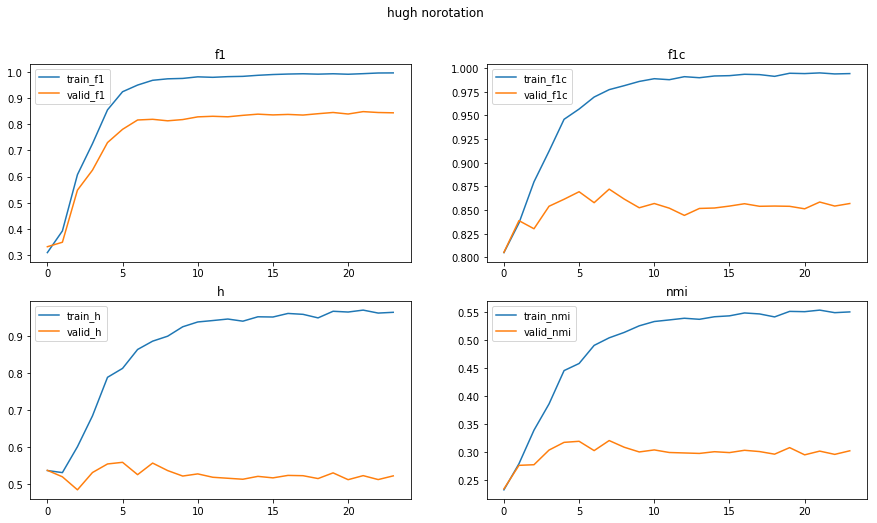

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,hugh norotation,24,0.996372,0.994215,0.964344,0.549603,0.8438,0.856918,0.521814,0.302488


[499, 500, 500, 2000, 10]
(3959, 499)
SGD {'lr': 0.01, 'momentum': 0.9}
[ 8 13 14 20 23 28 29 31 32 39 40 43]
[0.41252956 0.19641612 0.13914125]


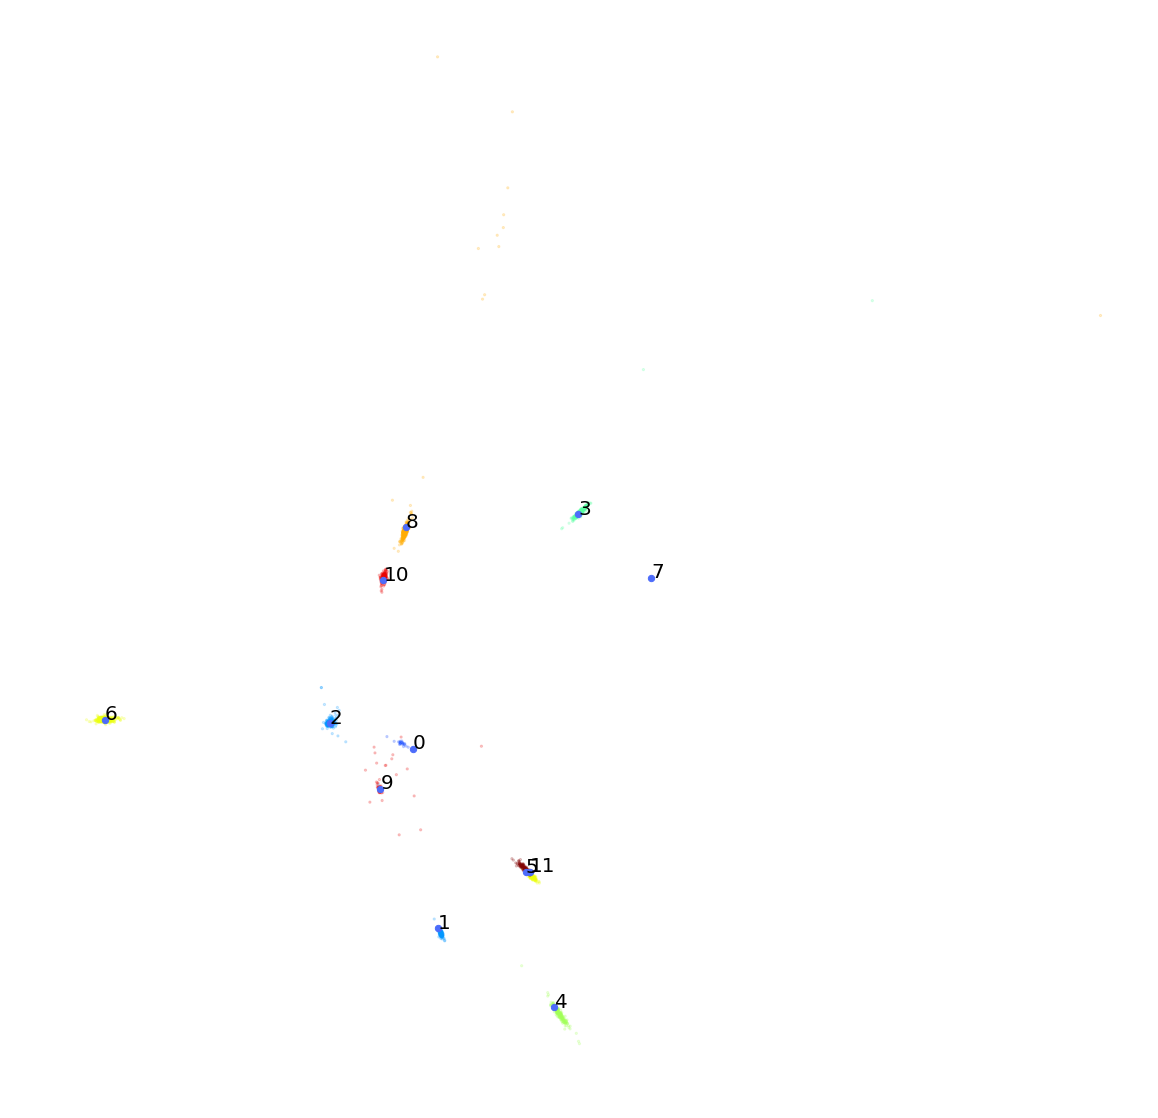

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,23,0.996372,0.994215,0.964344,0.549603,0.8438,0.856918,0.521814,0.302488


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
8,1,21,1.000000
13,1,179,1.000000
14,0,1135,0.997357
20,0,330,0.993939
23,1,221,1.000000
28,1,150,1.000000
29,0,802,1.000000
31,1,1,1.000000
32,1,726,0.986226
39,1,87,1.000000


In [14]:
with open('mnt/subjects/split_hugh_norotation_xy.pkl', 'rb') as f:
    splits = pickle.load(f)
    
x_test, y_test = splits['test']
x_train, y_train = splits['train']
x_valid, y_valid = splits['valid']
x_train_dev, y_train_dev = splits['train_dev']

save_dir = 'mnt/clustering_models/aws/hugh/norotation/multitask_1-2018-12-04T19:04:56'
from muon.dissolving.multitask import Config as MConfig
config = MConfig.load(os.path.join(save_dir, 'config.json'))
print(config.__dict__)

print(os.path.isfile(config.save_weights[0]))

report_runs([(save_dir, 'hugh norotation')])
metrics, cmap, pca = analyze_multitask(splits, save_dir)

True


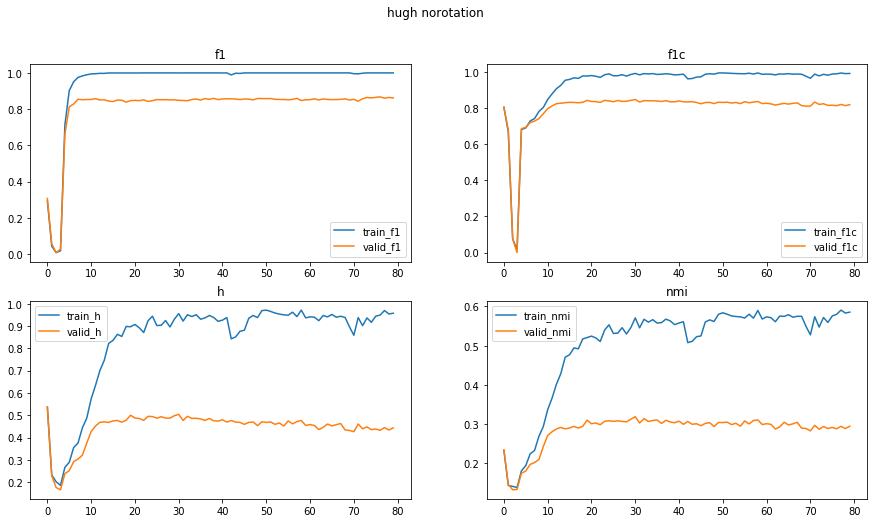

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,hugh norotation,24,0.996372,0.994215,0.964344,0.549603,0.8438,0.856918,0.521814,0.302488


[499, 500, 500, 2000, 10]
(3959, 499)
SGD {'lr': 0.01, 'momentum': 0.9}
[ 0  3  6  9 14 16 25 31 43]
[0.66928136 0.08939451 0.04877944]


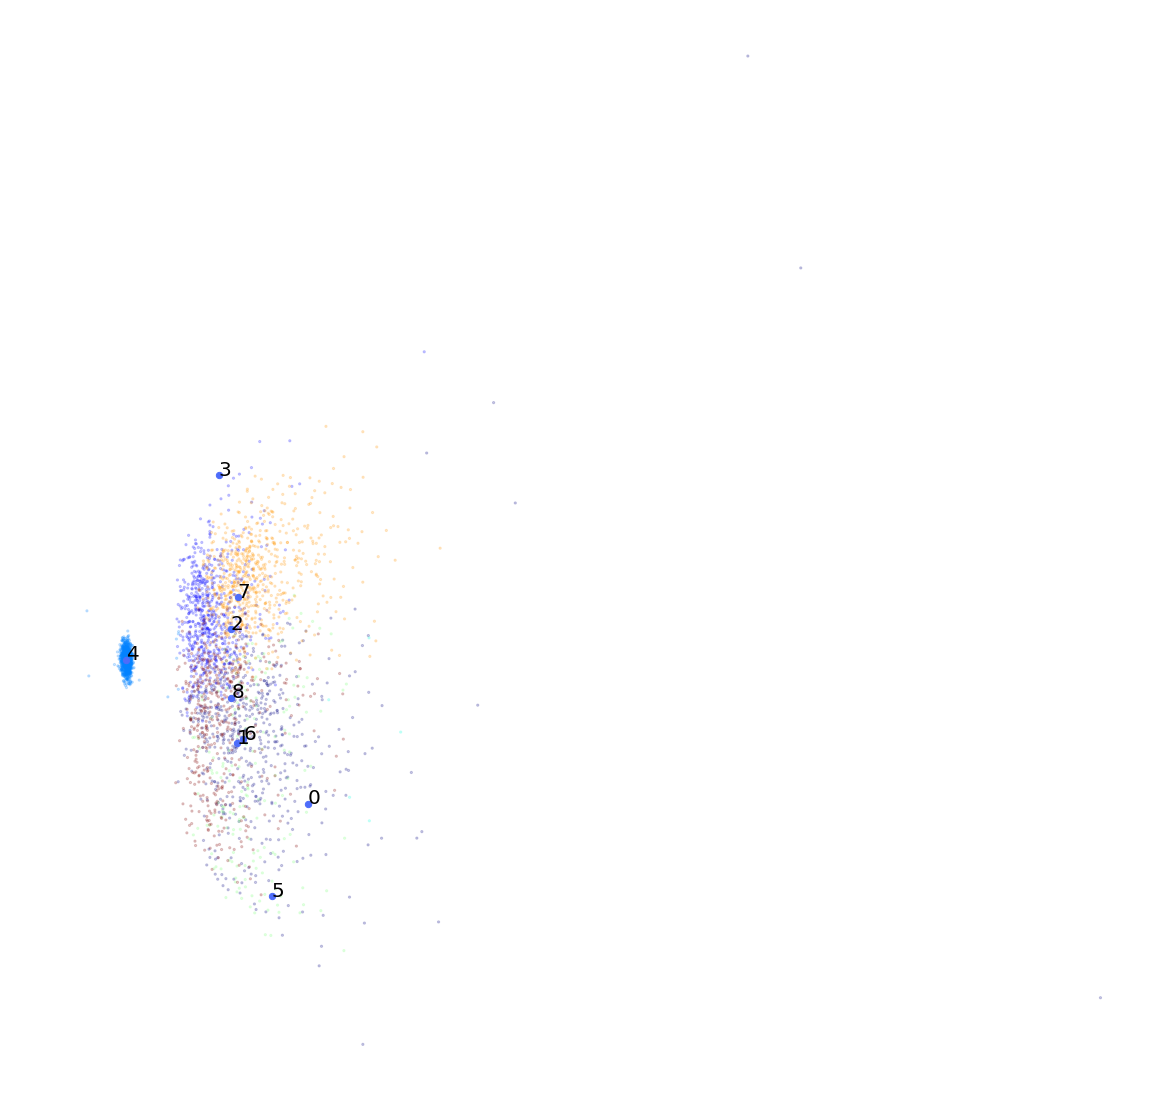

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,79,0.998549,0.992075,0.957009,0.585621,0.861007,0.819261,0.443462,0.294827


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
0,0,25,0.880000
3,0,540,1.000000
6,0,618,1.000000
9,0,71,1.000000
14,1,1386,0.993506
16,0,5,1.000000
25,0,186,1.000000
31,0,675,1.000000
43,0,453,1.000000


In [15]:
with open('mnt/subjects/split_hugh_norotation_xy.pkl', 'rb') as f:
    splits = pickle.load(f)
    
x_test, y_test = splits['test']
x_train, y_train = splits['train']
x_valid, y_valid = splits['valid']
x_train_dev, y_train_dev = splits['train_dev']

save_dir = 'mnt/clustering_models/aws/hugh/norotation/multitask_1-2018-12-06T00:23:31'

print(os.path.isfile(config.save_weights[0]))

report_runs([(save_dir, 'hugh norotation')])
metrics, cmap, pca = analyze_multitask(splits, save_dir)

{'update_interval': 140, 'n_clusters': 50, 'tol': 0.001, 'maxiter': 200, 'splits_file': '/data/lucifer1.2/users/larai002/muon_data/subjects/split_hugh_norotation_xy.pkl', 'batch_size': 256, 'n_classes': 2, 'source_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/multitask_1-2018-12-06T00:23:31/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/multitask_1-2018-12-06T00:23:31/best_train_dev_loss.h5'], 'source_dir': '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/multitask_1-2018-12-06T00:23:31', 'nodes': [500, 500, 2000, 10], 'save_interval': 5, 'save_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/redec_1-2018-12-06T00:32:22/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/redec_1-2018-12-06T00:32:22/DEC_model_final.h5'], 'save_dir': '/data/lucifer1.2/users/larai002/muon_data

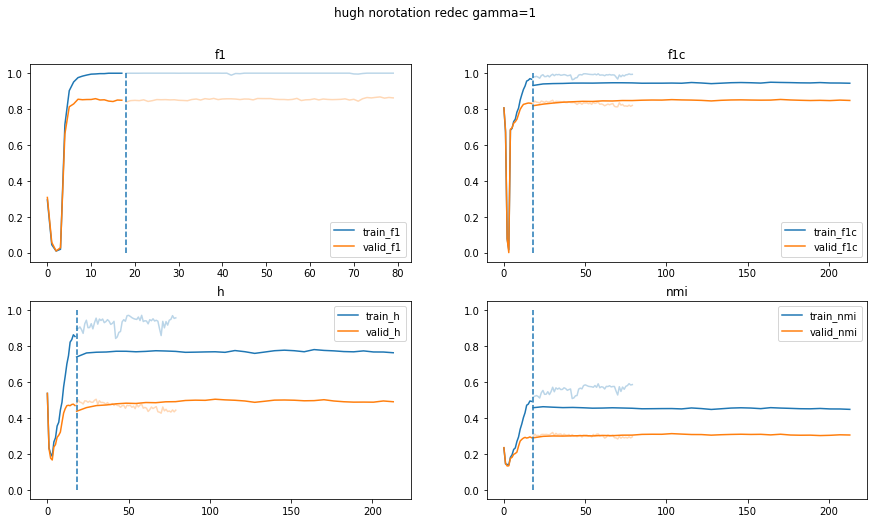

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,hugh norotation redec gamma=1,195.782609,NaN,0.942546,0.762725,0.447686,NaN,0.846695,0.490069,0.30499


[499, 500, 500, 2000, 10]
(3959, 499)
SGD {'lr': 0.01, 'momentum': 0.9}
[ 0  3  6  9 14 25 31 43]
[0.80207133 0.14180905 0.03558212]


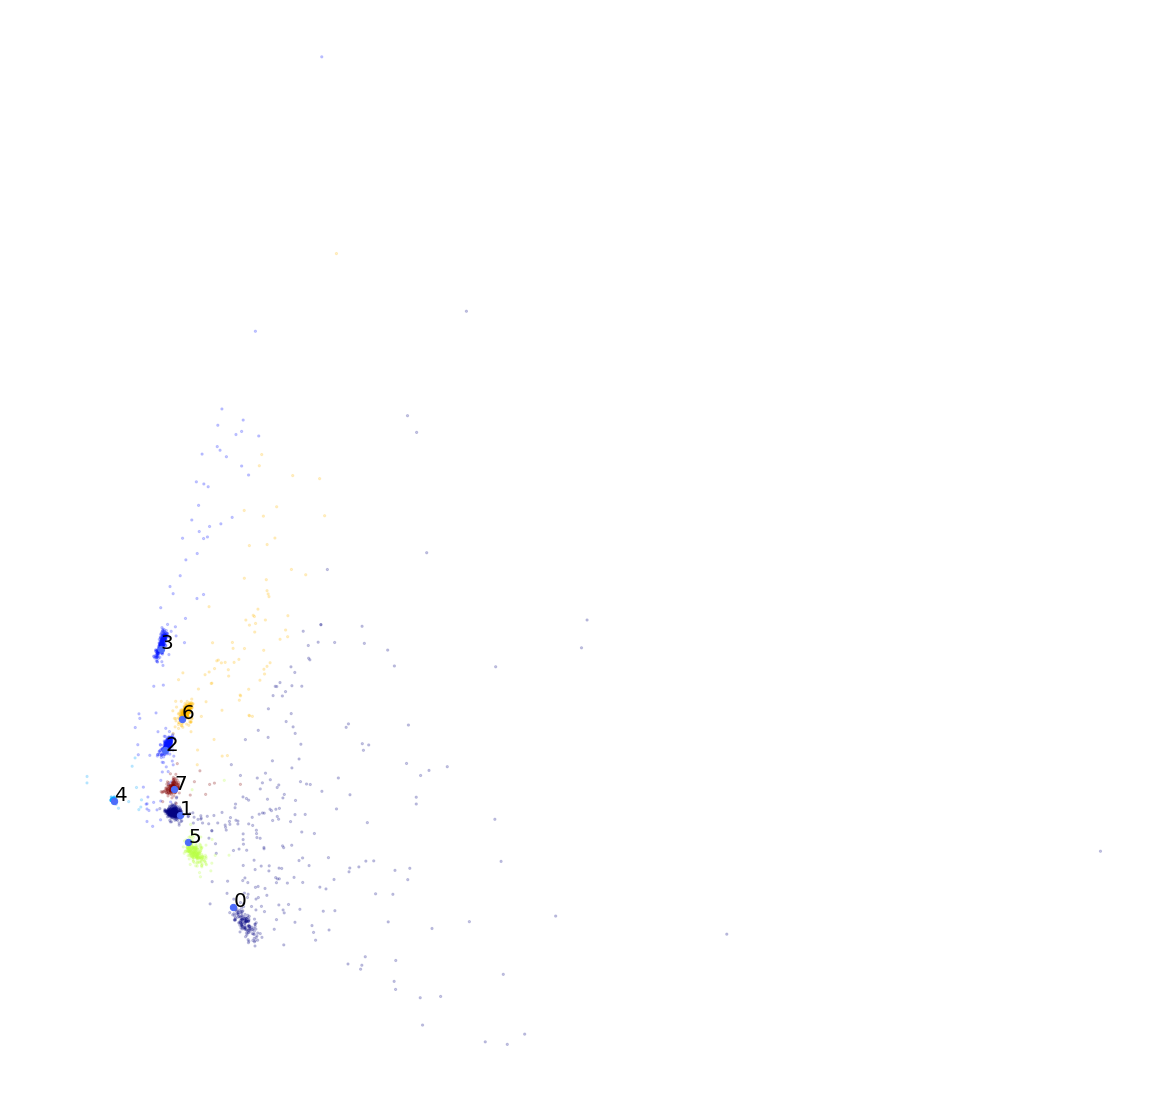

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,194.782609,NaN,0.942546,0.762725,0.447686,NaN,0.846695,0.490069,0.30499


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
0,0,335,0.99403
3,0,504,1.00000
6,0,335,1.00000
9,0,361,0.99723
14,1,1387,0.99279
25,0,257,1.00000
31,0,536,1.00000
43,0,244,1.00000


In [4]:
# with open('mnt/subjects/split_hugh_norotation_xy.pkl', 'rb') as f:
#     splits = pickle.load(f)
    
# x_test, y_test = splits['test']
# x_train, y_train = splits['train']
# x_valid, y_valid = splits['valid']
# x_train_dev, y_train_dev = splits['train_dev']

save_dir = 'mnt/clustering_models/aws/hugh/norotation/redec_1-2018-12-06T00:32:22'
print(RConfig.load(save_dir+'/config.json'))

# print(os.path.isfile(config.save_weights[0]))

report_runs([(save_dir, 'hugh norotation redec gamma=1')])
metrics, cmap, pca = analyze_redec(save_dir)

{'update_interval': 140, 'n_clusters': 50, 'tol': 0.001, 'maxiter': 200, 'splits_file': '/data/lucifer1.2/users/larai002/muon_data/subjects/split_hugh_norotation_xy.pkl', 'batch_size': 256, 'n_classes': 2, 'source_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/multitask_1-2018-12-04T19:04:56/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/multitask_1-2018-12-04T19:04:56/best_train_dev_loss.h5'], 'source_dir': '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/multitask_1-2018-12-04T19:04:56', 'nodes': [500, 500, 2000, 10], 'save_interval': 5, 'save_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/redec_1-2018-12-05T20:08:06/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/hugh/norotation/redec_1-2018-12-05T20:08:06/DEC_model_final.h5'], 'save_dir': '/data/lucifer1.2/users/larai002/muon_data

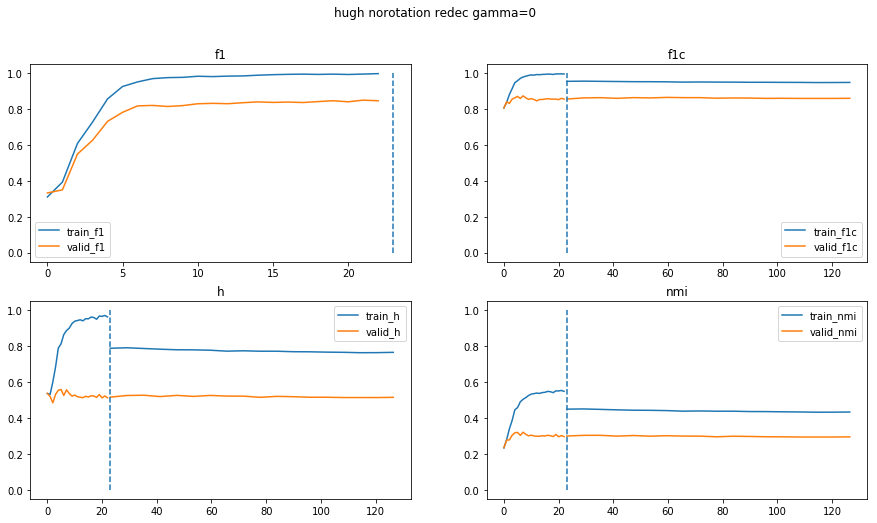

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,hugh norotation redec gamma=0,104.478261,NaN,0.946995,0.764966,0.432861,NaN,0.858671,0.51456,0.294592


[499, 500, 500, 2000, 10]
(3959, 499)
SGD {'lr': 0.01, 'momentum': 0.9}
[ 8 13 14 20 23 28 29 31 32 39 40 43]
[0.41002214 0.1944481  0.1384905 ]


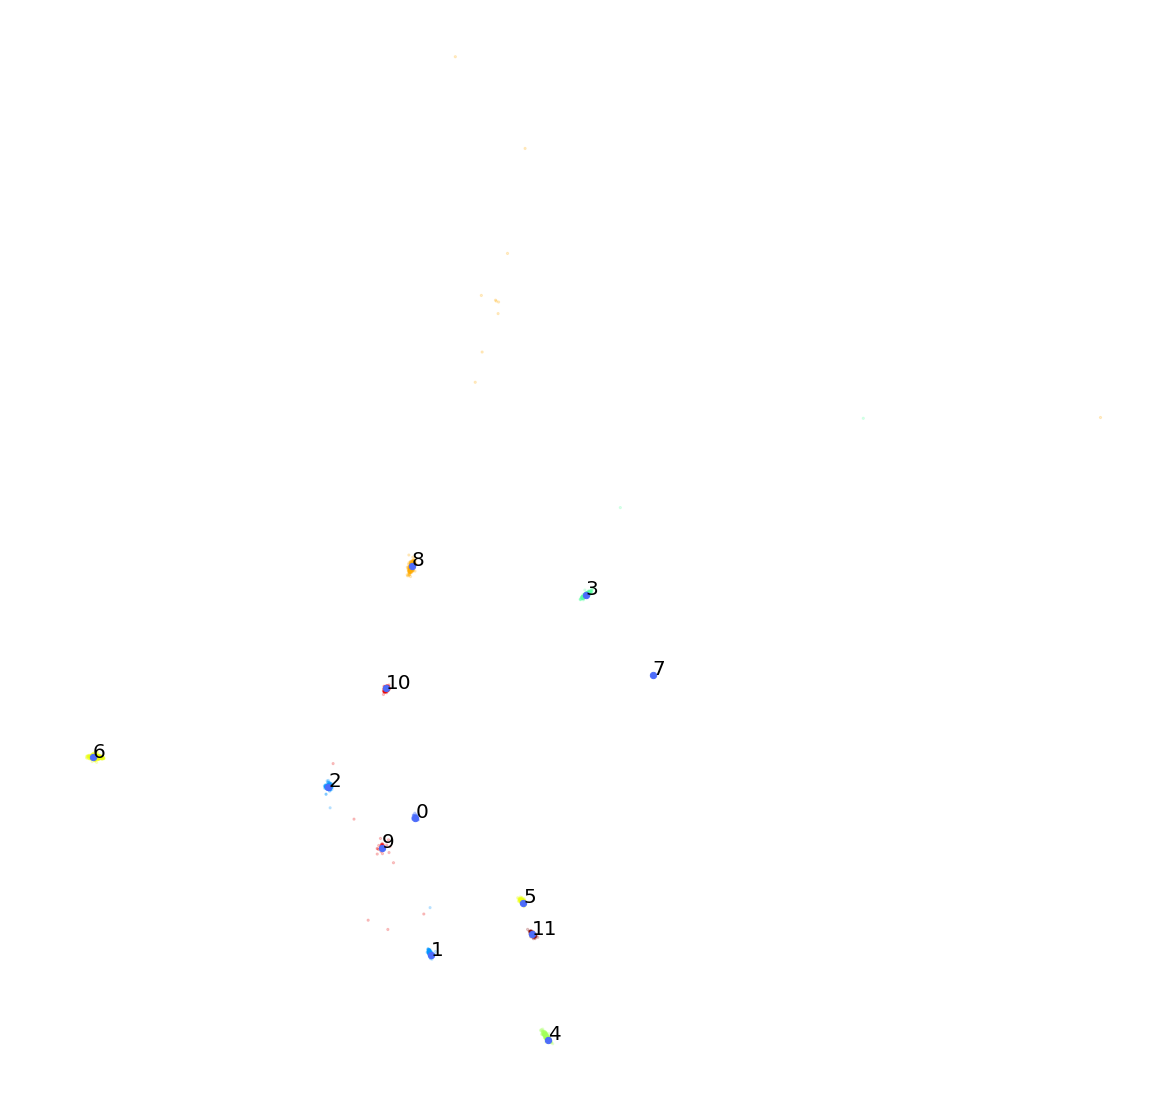

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,103.478261,NaN,0.946995,0.764966,0.432861,NaN,0.858671,0.51456,0.294592


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
8,1,21,1.000000
13,1,179,1.000000
14,0,1133,0.998235
20,0,330,0.993939
23,1,221,1.000000
28,1,150,1.000000
29,0,802,1.000000
31,1,1,1.000000
32,1,726,0.986226
39,1,88,0.988636


In [11]:
# with open('mnt/subjects/split_hugh_norotation_xy.pkl', 'rb') as f:
#     splits = pickle.load(f)
    
# x_test, y_test = splits['test']
# x_train, y_train = splits['train']
# x_valid, y_valid = splits['valid']
# x_train_dev, y_train_dev = splits['train_dev']

save_dir = 'mnt/clustering_models/aws/hugh/norotation/redec_1-2018-12-05T20:08:06'
print(RConfig.load(save_dir+'/config.json'))

# print(os.path.isfile(config.save_weights[0]))

report_runs([(save_dir, 'hugh norotation redec gamma=0')])
metrics, cmap, pca = analyze_redec(save_dir)

{'tol': 0.001, 'source_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/dec/dec_no_labels/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/dec/dec_no_labels/DEC_model_final.h5'], 'alpha': 1.0, 'n_clusters': 50, 'splits_file': '/data/lucifer1.2/users/larai002/muon_data/subjects/split_volunteer_norotation_xy.pkl', 'maxiter': 100, 'beta': 0.0, 'save_interval': 5, 'save_dir': '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:07', 'optimizer': ['SGD', {'momentum': 0.9, 'lr': 0.001}], 'nodes': [500, 500, 2000, 10], 'update_interval': 1, 'save_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:07/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:07/DEC_model_final.h5'], 'n_classes': 2, 'batch_size': 256, 'gamma': 1.0,

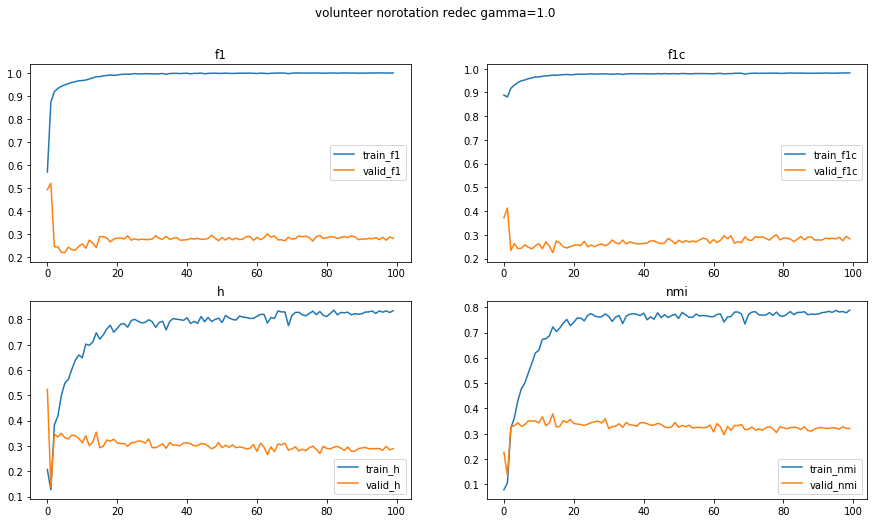

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,volunteer norotation redec gamma=1.0,100,0.999271,0.982112,0.834648,0.788446,0.279787,0.282381,0.289266,0.321513


[499, 500, 500, 2000, 10]
(44319, 499)
SGD {'momentum': 0.9, 'lr': 0.001}
[ 6 14 20 38 40]
[0.716274   0.04475047 0.03942364]


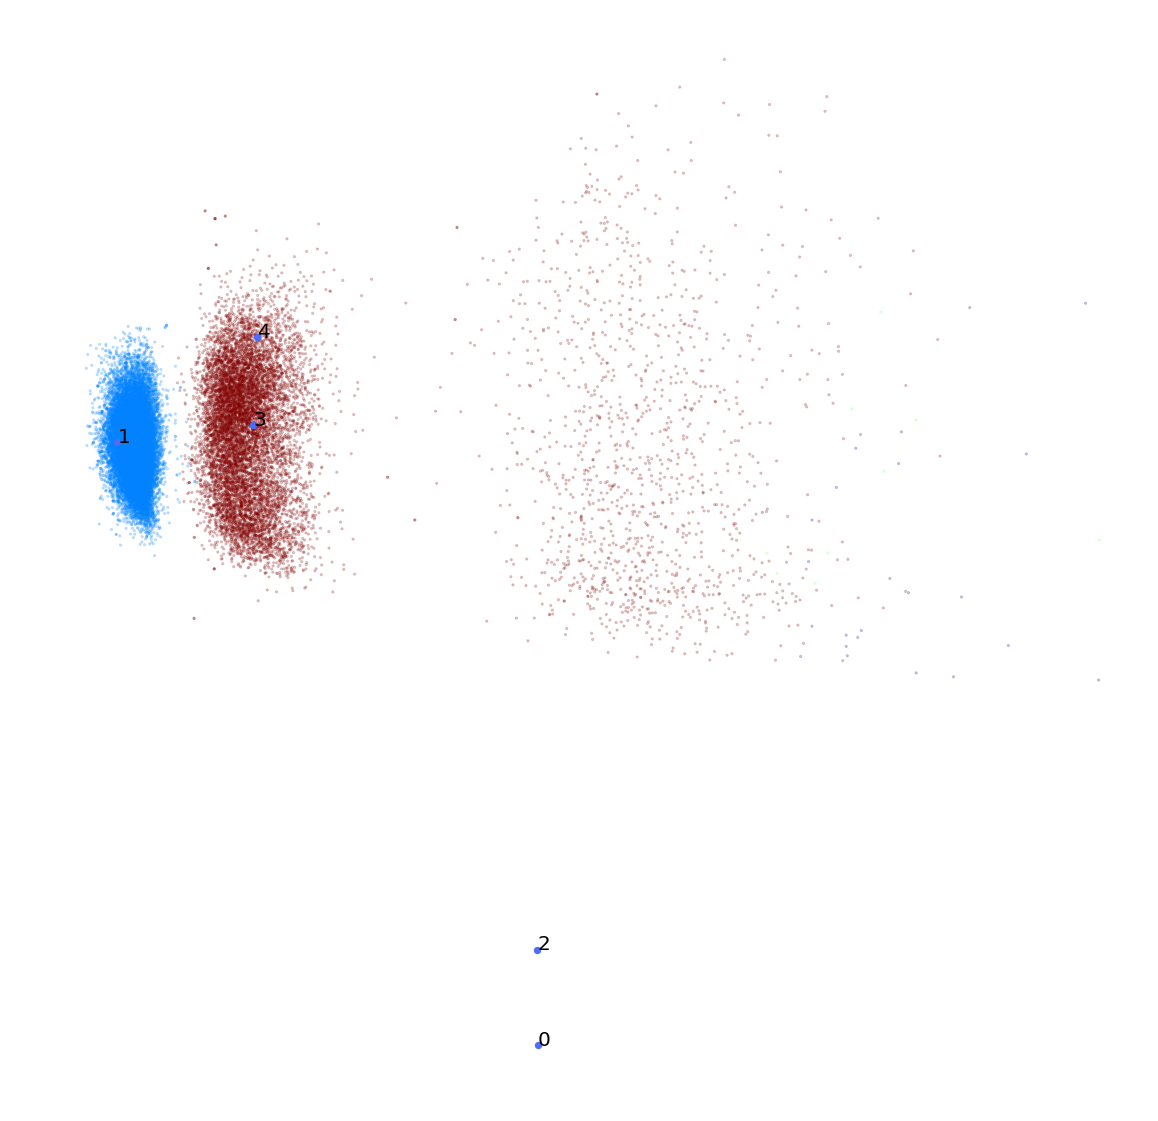

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,99,0.999271,0.982112,0.834648,0.788446,0.279787,0.282381,0.289266,0.321513


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
6,1,24,1.000000
14,1,32993,0.999212
20,1,9,1.000000
38,0,11036,0.899239
40,1,257,0.665370


In [15]:
save_dir = 'mnt/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:07'
config = MConfig.load(save_dir+'/config.json')
print(config)
print('gamma', config.gamma)

report_runs([(save_dir, 'volunteer norotation redec gamma=1.0')])
metrics, cmap, pca = analyze_multitask(save_dir)


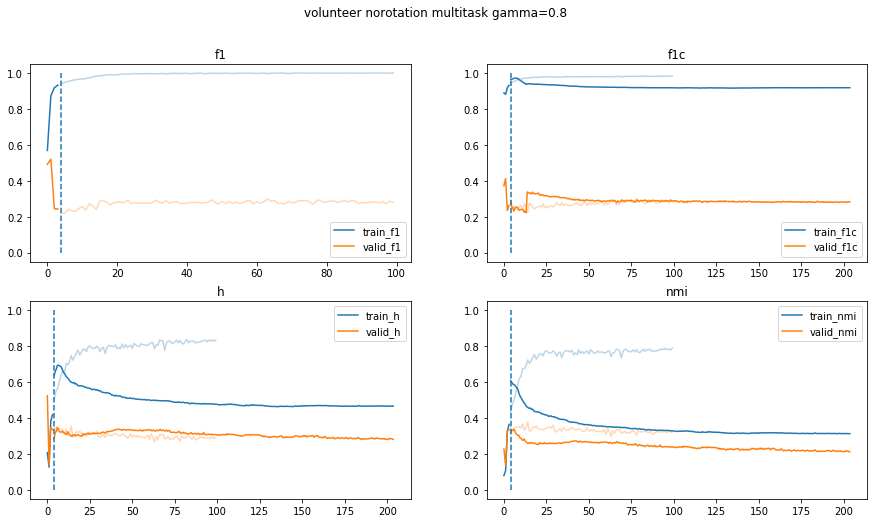

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,volunteer norotation multitask gamma=0.8,200.393939,NaN,0.917491,0.465691,0.312699,NaN,0.281385,0.28013,0.211706


[499, 500, 500, 2000, 10]
(44319, 499)
SGD {'momentum': 0.9, 'lr': 0.01}
[ 6 14 20 31 38 40 42]
[9.8747021e-01 1.1816243e-02 5.1378709e-04]


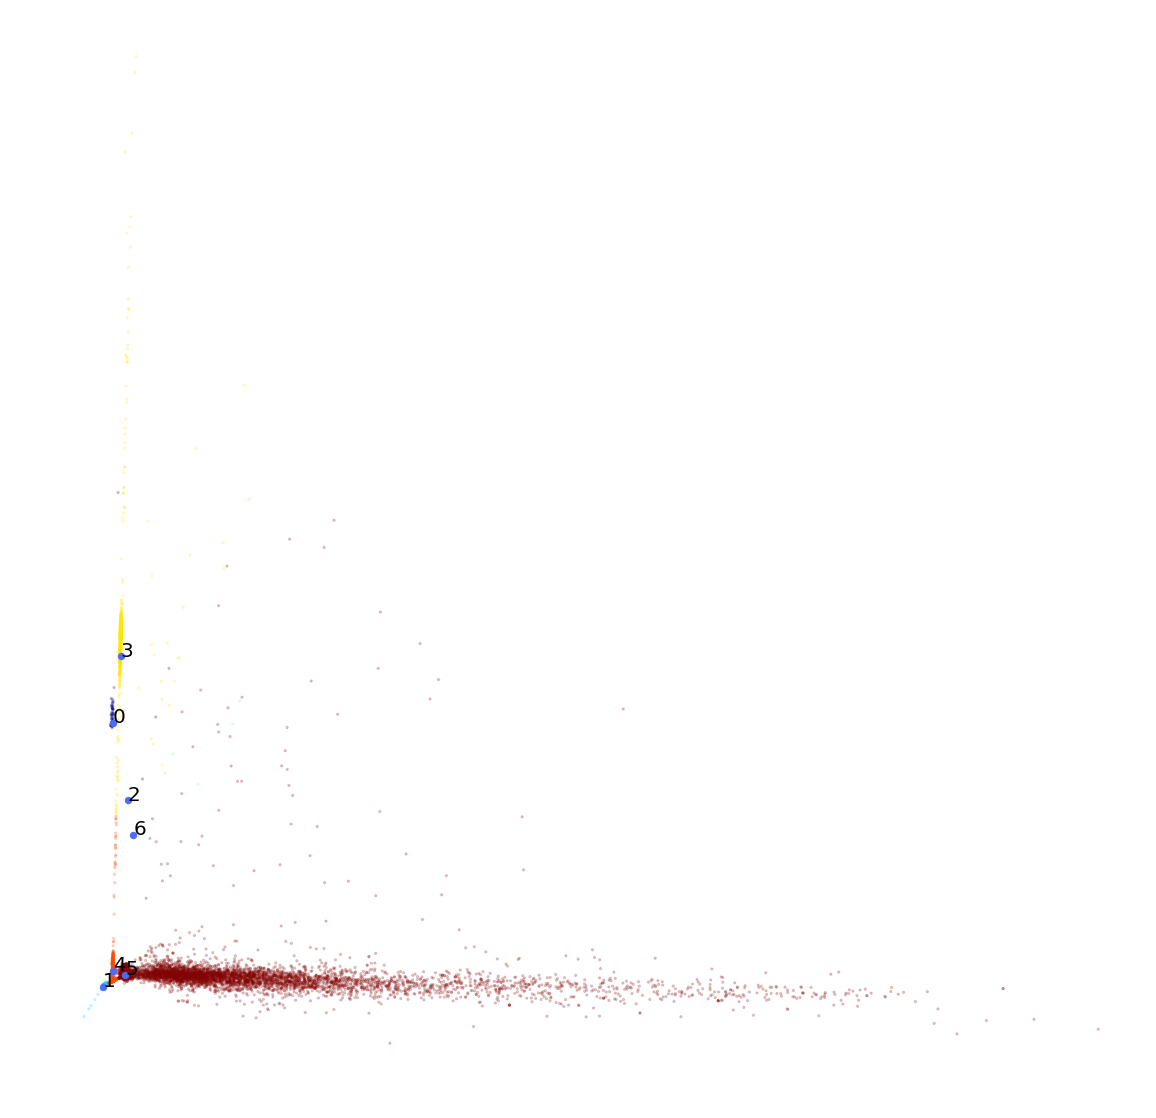

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,199.393939,NaN,0.917491,0.465691,0.312699,NaN,0.281385,0.28013,0.211706


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
6,1,64,1.000000
14,1,25104,0.999920
20,1,6,1.000000
31,1,1086,0.969613
38,0,9300,0.780753
40,1,6257,0.726706
42,1,2502,0.588329


In [25]:
save_dir = 'mnt/clustering_models/aws/volunteer/norotation/redec_1-2018-12-06T03:43:08'
config = RConfig.load(save_dir+'/config.json')

report_runs([(save_dir, 'volunteer norotation multitask gamma=0.8')])
metrics, cmap, pca = analyze_redec(save_dir)


{'tol': 0.001, 'source_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/dec/dec_no_labels/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/dec/dec_no_labels/DEC_model_final.h5'], 'alpha': 1.0, 'n_clusters': 50, 'splits_file': '/data/lucifer1.2/users/larai002/muon_data/subjects/split_volunteer_norotation_xy.pkl', 'maxiter': 100, 'beta': 0.0, 'save_interval': 5, 'save_dir': '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:13', 'optimizer': ['SGD', {'momentum': 0.9, 'lr': 0.001}], 'nodes': [500, 500, 2000, 10], 'update_interval': 1, 'save_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:13/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:13/DEC_model_final.h5'], 'n_classes': 2, 'batch_size': 256, 'gamma': 0.7,

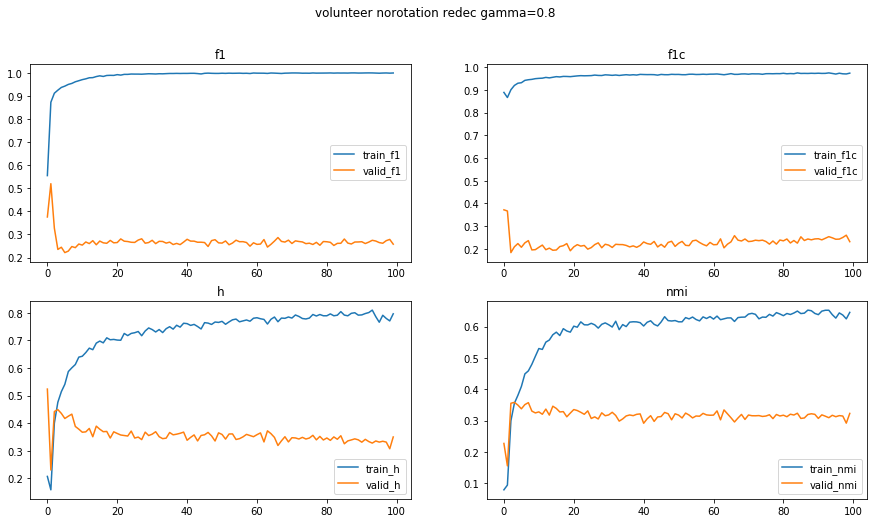

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,volunteer norotation redec gamma=0.8,100,0.998877,0.973724,0.796384,0.6455,0.258104,0.231551,0.349889,0.32295


[499, 500, 500, 2000, 10]
(44319, 499)
SGD {'momentum': 0.9, 'lr': 0.001}
[ 2 13 14 20 31 38]
[0.6918255  0.06267665 0.04017019]


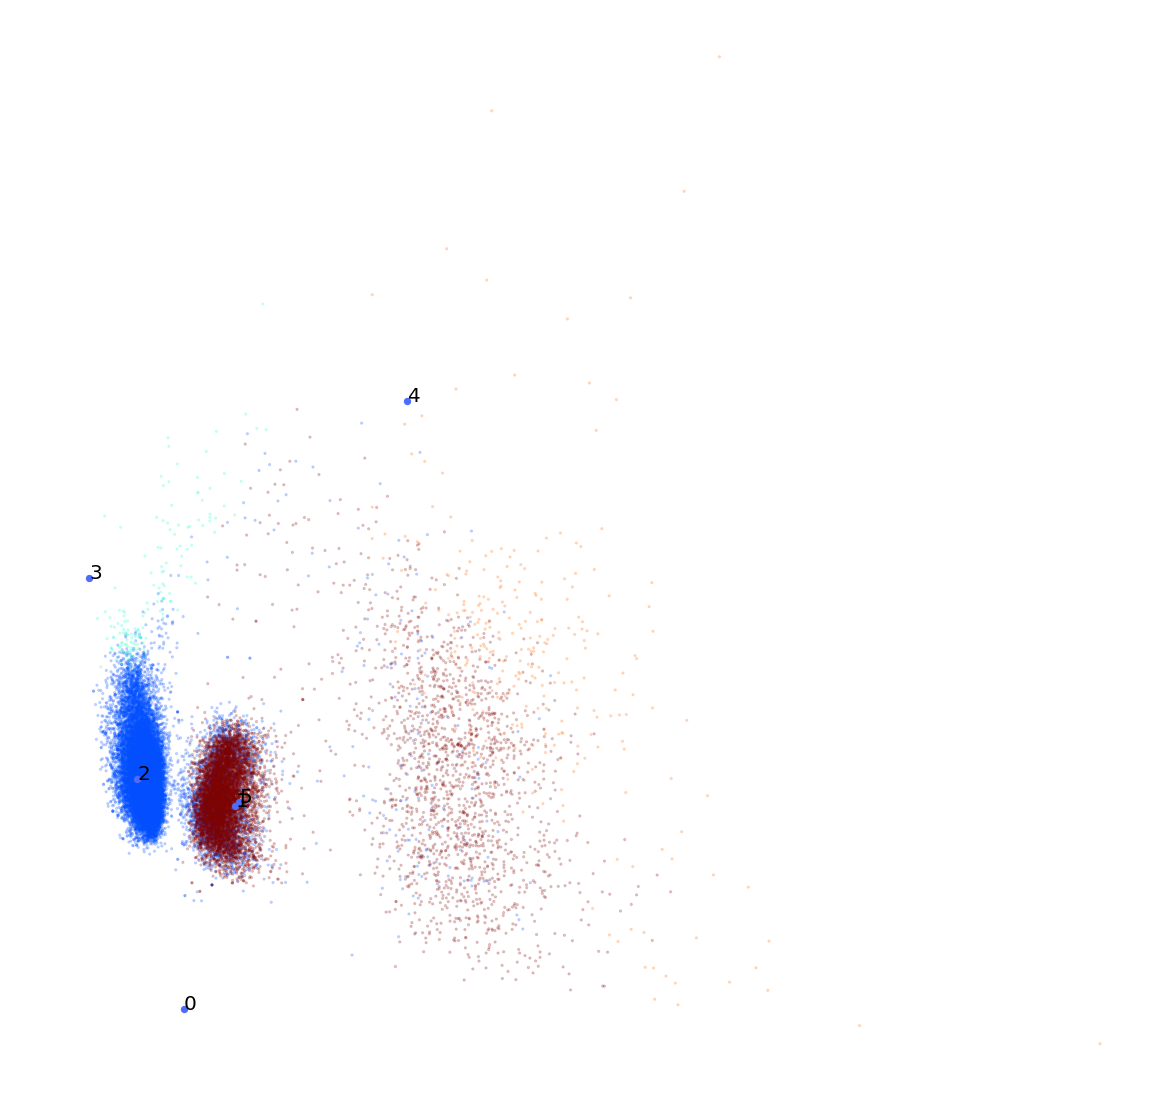

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,99,0.998877,0.973724,0.796384,0.6455,0.258104,0.231551,0.349889,0.32295


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
2,1,4,0.750000
13,0,3560,0.948596
14,1,32035,0.997347
20,1,159,1.000000
31,1,293,1.000000
38,0,8268,0.794993


In [14]:
save_dir = 'mnt/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:13'
config = MConfig.load(save_dir+'/config.json')
print(config)
print('gamma', config.gamma)

report_runs([(save_dir, 'volunteer norotation multitask gamma=0.8')])
metrics, cmap, pca = analyze_multitask(save_dir)

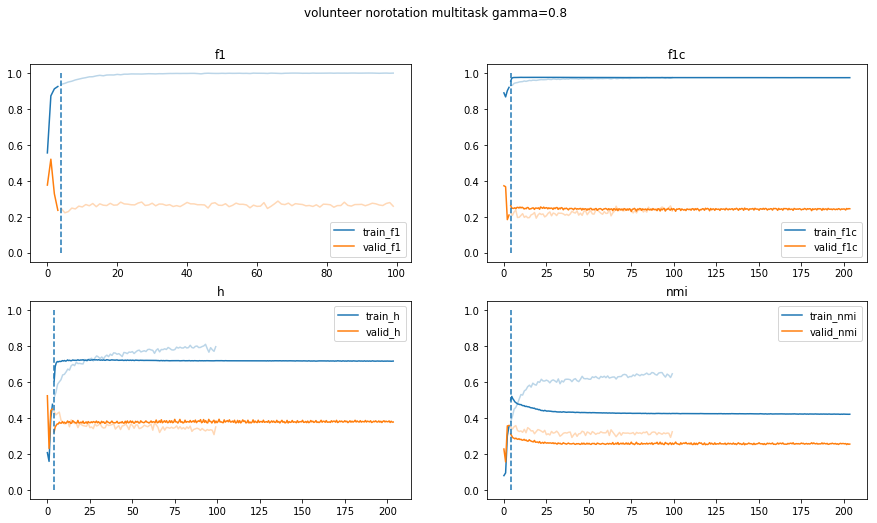

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,volunteer norotation multitask gamma=0.8,200.393939,NaN,0.973495,0.716397,0.420577,NaN,0.244145,0.377276,0.254597


[499, 500, 500, 2000, 10]
(44319, 499)
SGD {'momentum': 0.9, 'lr': 0.01}
[ 9 13 14 20 31 32 33 38]
[0.66061115 0.32085773 0.01819057]


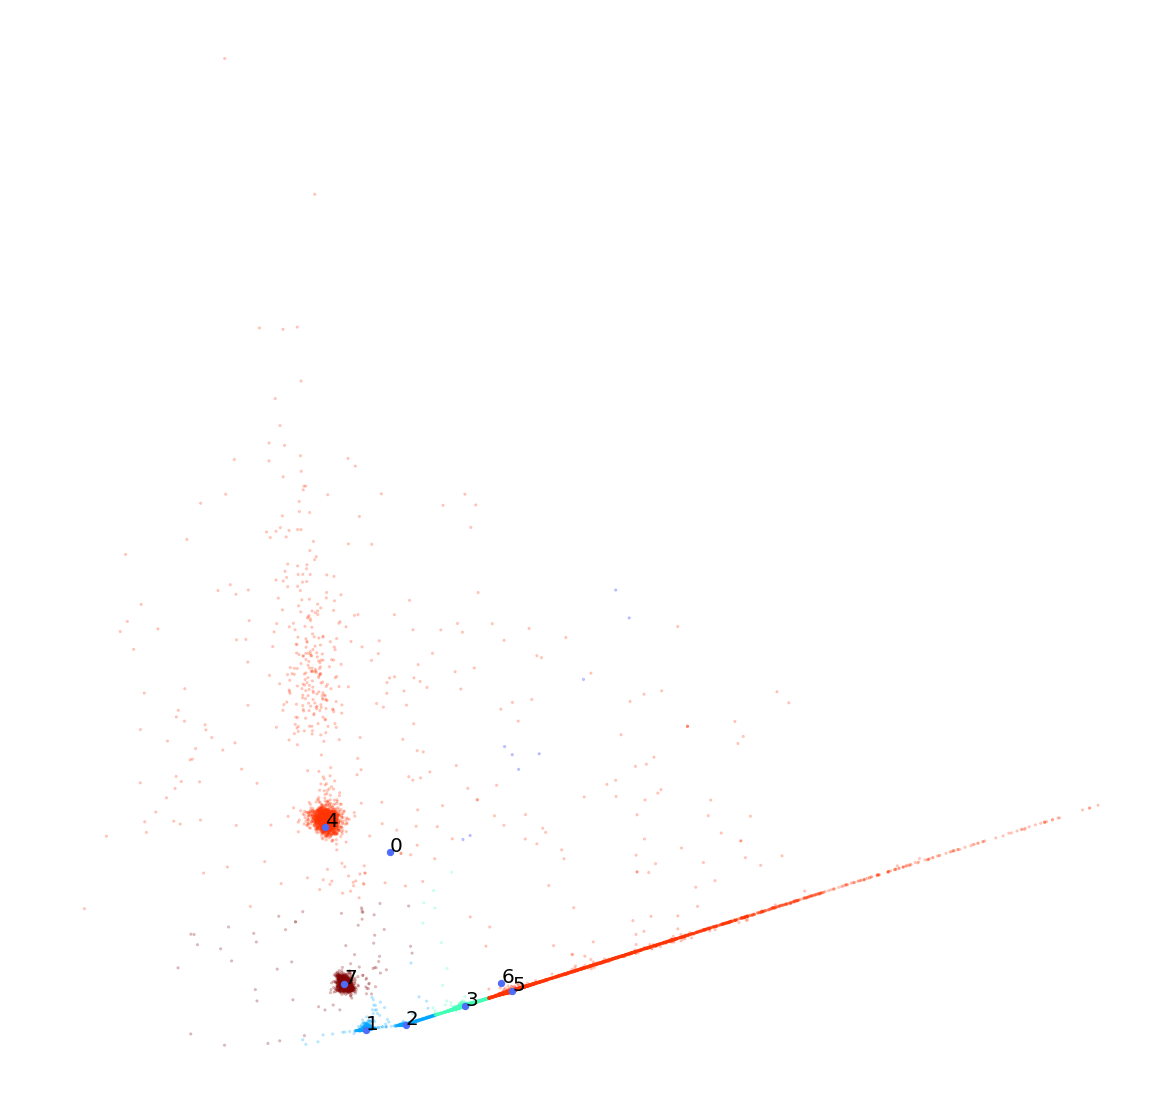

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,199.393939,NaN,0.973495,0.716397,0.420577,NaN,0.244145,0.377276,0.254597


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
9,1,9,1.000000
13,0,5118,0.971082
14,1,19612,0.999541
20,1,6383,0.998590
31,1,2174,0.995860
32,1,5927,0.998144
33,1,4,1.000000
38,0,5092,0.987431


In [26]:
save_dir = 'mnt/clustering_models/aws/volunteer/norotation/redec_1-2018-12-06T03:43:37'
config = RConfig.load(save_dir+'/config.json')

report_runs([(save_dir, 'volunteer norotation multitask gamma=0.8')])
metrics, cmap, pca = analyze_redec(save_dir)


{'tol': 0.001, 'source_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/dec/dec_no_labels/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/dec/dec_no_labels/DEC_model_final.h5'], 'alpha': 1.0, 'n_clusters': 50, 'splits_file': '/data/lucifer1.2/users/larai002/muon_data/subjects/split_volunteer_norotation_xy.pkl', 'maxiter': 100, 'beta': 0.0, 'save_interval': 5, 'save_dir': '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:07', 'optimizer': ['SGD', {'momentum': 0.9, 'lr': 0.001}], 'nodes': [500, 500, 2000, 10], 'update_interval': 1, 'save_weights': ['/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:07/ae_weights.h5', '/data/lucifer1.2/users/larai002/muon_data/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:07/DEC_model_final.h5'], 'n_classes': 2, 'batch_size': 256, 'gamma': 1.0,

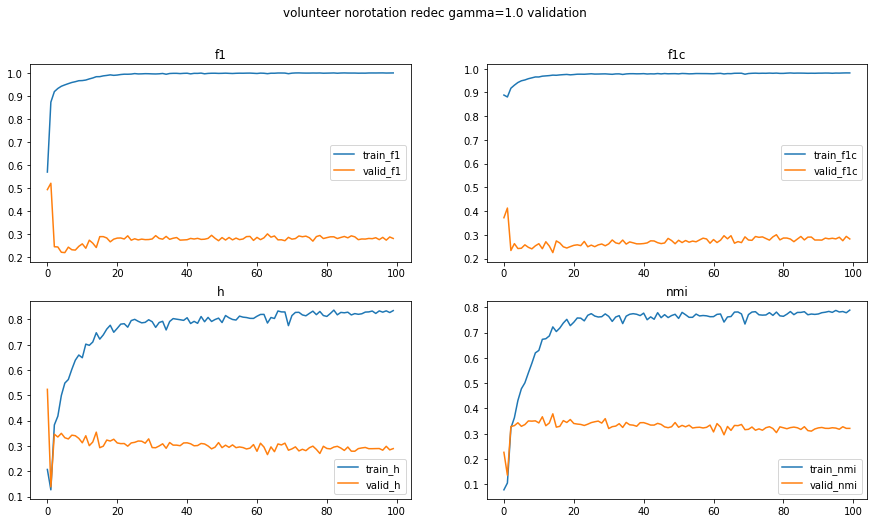

,title,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,volunteer norotation redec gamma=1.0 validation,100,0.999271,0.982112,0.834648,0.788446,0.279787,0.282381,0.289266,0.321513


[499, 500, 500, 2000, 10]
(7423, 499)
SGD {'momentum': 0.9, 'lr': 0.001}
[ 6 14 38 40]
[0.5855093  0.07039376 0.06074221]


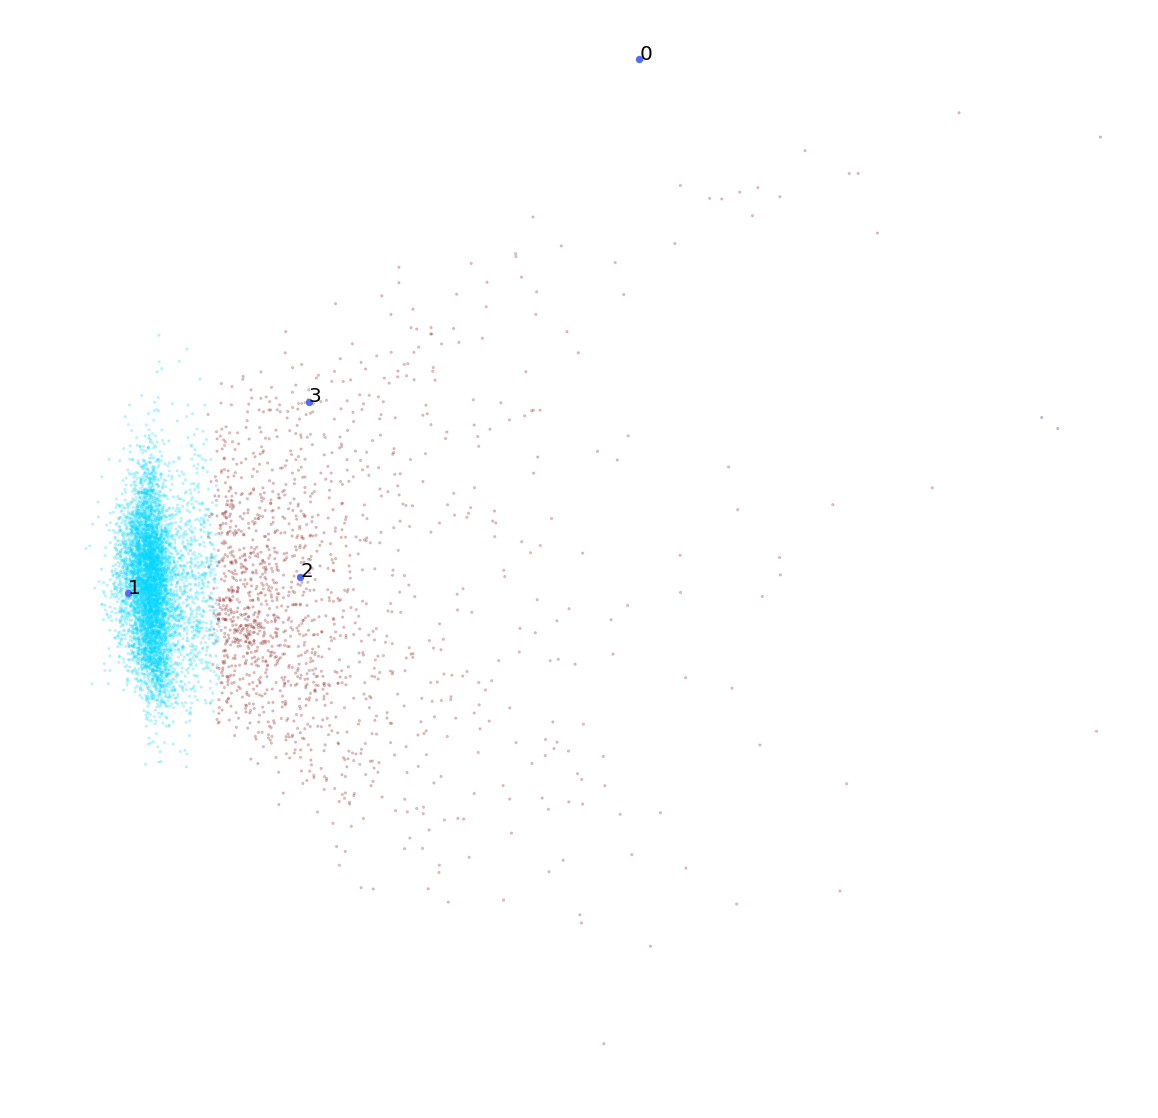

,iteration,train_f1,train_f1c,train_h,train_nmi,valid_f1,valid_f1c,valid_h,valid_nmi
0,99,0.999271,0.982112,0.834648,0.788446,0.279787,0.282381,0.289266,0.321513


/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/larai002/Zooniverse/repos/muon/venv/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,majority class,n_assigned,purity
6,1,3,1.000000
14,0,5896,0.794776
38,1,1512,0.914683
40,1,12,0.916667


In [23]:
save_dir = 'mnt/clustering_models/aws/volunteer/norotation/multitask_1-2018-12-06T02:51:07'
config = MConfig.load(save_dir+'/config.json')
print(config)
print('gamma', config.gamma)

report_runs([(save_dir, 'volunteer norotation redec gamma=1.0 validation')])
metrics, cmap, pca = analyze_multitask(save_dir, 'valid')


The validation measures are so much lower than the training measures because the training is measured against the volunteer labels, and the validation is measured against hugh's labels. The model is learning the relationship based on the volunteer labels, but as the volunteer labels have an f1_socre roughly 0.2 compared to hugh's labels the validation breaks down